### The purpose of this notebook is to create a synthetic dataset to train a Deeppavlov NER BERT model for NER task.

In [299]:
# importing required libraries

import pandas as pd
import numpy as np
import os
import re
import tqdm
import pytils.translit
from collections import OrderedDict
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy.stats import skewnorm
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')
os.chdir('/home/andreybondar/Desktop/datasets/')

### I. Substracting 'PER', 'ORG' and 'LOC' from instagram text data to get a clean text data with 'O' taged words which can be potentially used for BIO  markup synthetic dataset generation.
To learn what is BIO tagging:

https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

In [2]:
# importing the data scrapped from the instagram (we are using russian speaking part of Instagram)

df_instagram = pd.read_excel('instagram_scrapped_data.xlsx')
df_instagram

,text
0,karpova_ginekolog Гинеколог🔹Репродуктолог🔹ЭКО ...
1,aubakirov.bulat Булат Аубакиров ОБЕРЕГАЙ СВОЮ ...
2,dr_allademidova Кардиолог Терапевт Москва 🔺нау...
3,dr.kozhevnikova_m КОЖЕВНИКОВА Мария 💉НЕОЧЕРЕДН...
4,masterdent05 СТОМАТОЛОГИЯ МАСТЕРДЕНТ 📍Абубакар...
...,...
12414,oblastnaia_stomatologiia ОБЛАСТНАЯ СТОМАТОЛОГИ...
12415,doctor_lung Врач Ростов-на-Дону Анна Сергеевна...
12416,stomalux_anapa Стоматология в Анапе🦷СтомаЛюкс ...
12417,dr.tamaranm Мальцева Тамара Николаевна 👩🏻‍⚕️Вр...


In [5]:
# creating functions for cleaning up our instagram data

def replace_bad_characters(text):
    '''replace 'й' by original 'й' and 'ё' by original 'ё' (some caracters have len() == 2 instead of  == 1)'''
    text_corrected = []
    for character in text:
        if character == 'й'[1]: 
            text_corrected[-1] = 'й'     
            continue 
        elif character == 'ё'[1]:
            text_corrected[-1] = 'ё'     
            continue
        else:
            text_corrected.append(character)      
    text = ''.join(text_corrected)
    return text

def prepare_text(sentence):
    '''general text preparation'''
    text = re.sub(r'\s+', ' ', sentence).strip().lower() # deleting extra spaces and lowering the data
    text = replace_bad_characters(text) # replacing bad characters
    text = re.sub('[ó]', 'о', text) # replacing 'ó' with 'о'
    text = re.sub('[ё]', 'е', text) # replacing 'ё' with 'е'
    text = re.sub(r'[+\(]?[0-9][0-9 .\-\(\)]{4,15}[0-9]', ' ', text) # phone number deletion
    text = re.sub(r'[^А-Яа-яA-Za-zёй ]+', ' ', text) # picking only english and russian text 
    text = pytils.translit.detranslify(text) # detranslify english text to russian
    text = re.sub(r'\s+', ' ', text).strip().lower()
    text = re.sub('[ó]', 'о', text)
    text = re.sub('[ё]', 'е', text)

    return text

In [6]:
# cleaning up instagram data
instagram_prepared_for_ner = df_instagram['text'].apply(lambda text: prepare_text(text))

In [7]:
instagram_prepared_for_ner

0        карпова гинеколог гинеколог репродуктолог эко ...
1        аубакиров булат булат аубакиров оберегай свою ...
2        др алладемидова кардиолог терапевт москва науч...
3        др кожевникова м кожевникова мария неочередной...
4        мастердент стоматология мастердент абубакарова...
                               ...                        
12414    областнаиа стоматологииа областная стоматологи...
12415    доcтор лунг врач ростов на дону анна сергеевна...
12416    стомалуx анапа стоматология в анапе стомалюкс ...
12417    др тамаранм мальцева тамара николаевна врач ак...
12418    cлиниcс ссму клиники сибгму мц профессор первы...
Name: text, Length: 12419, dtype: object

In [8]:
# example of the text before preparation and the text after preparation
k = 1000
print('Text before preparation: ', df_instagram.text[k], '\n')
print('Text after preparation: ', instagram_prepared_for_ner[k])

Text before preparation:  taping_dv Тейпирование Дальний Восток. Ковалева Мария Александровна 👩‍⚕️ Глав.врач МЦ "Далинь" 📲8-914-546-01-11. 📚 Обучающие семинары по мед. реабилитации, терапевтическому тейпированию. - https://fs-school.ru/sn 

Text after preparation:  тапинг дв тейпирование дальний восток ковалева мария александровна глав врач мц далинь обучающие семинары по мед реабилитации терапевтическому тейпированию хттпс фс щоол ру сн


In [9]:
# tokenizing instagram text data into separate words
joined_instagram = ' '.join(instagram_prepared_for_ner)
list_of_words_instagram = joined_instagram.split(' ')

# counting word frequencies of instagram words for counted word comparison
INST_d = {}
for i in list_of_words_instagram:
    INST_d[i] = INST_d.get(i, 0) + 1

In [10]:
# loading dataset with persons for counted word comparison

df_PER = pd.read_excel('per_org_loc.xlsx', 'PER')
df_PER = df_PER.fillna('')
df_PER['PER'] = df_PER['PER'].apply(lambda text: prepare_text(text))

In [11]:
df_PER

,PER
0,кочарян ширяева зенина елизавета александровна
1,магомедгаджиев магомедганипа ибрагимгаджиевич
2,джалилова таривердиева эльмира гадживердиевна
3,архангельский багдасарьянц дмитрий эдуардович
4,парцваниа виноградова екатерина владимировна
...,...
820615,кондратьева
820616,артурович
820617,калашникова
820618,степан


In [12]:
# general preparation of text data of df_PER for counted word comparison

PER_text = ' '.join(df_PER['PER'].to_list()).strip().lower()

PER_text = re.sub(r'[^.А-Яа-яA-Za-zёй ]+', ' ', PER_text)
PER_text = pytils.translit.detranslify(PER_text)

tokenizer = re.split(' ',  PER_text) * 6 # tokenization of all persons to separate words and multipliying by 6 (adding more weight to persons so we are sure that all persons were extracted)
tokenizer = [i for i in tokenizer if i != ''] # filtering empty strings

In [13]:
len(tokenizer)

12807420

In [14]:
tokenizer[0:10]

['кочарян',
 'ширяева',
 'зенина',
 'елизавета',
 'александровна',
 'магомедгаджиев',
 'магомедганипа',
 'ибрагимгаджиевич',
 'джалилова',
 'таривердиева']

In [15]:
# counting a word frequencies of PER words for counted word comparison

PER_d = {}
for i in tokenizer:
    PER_d[i] = PER_d.get(i, 0) + 1

In [16]:
# appliying the counted word comparison and finding the words that will be used for word extraction in our instagram text data

words_to_extract_PER = []

for word in list_of_words_instagram: # iterating over words of instagram because we are interested in them
    try:
        per_count = PER_d[word] # triying if the word exists in our PER_d dictionary, if exists returns word count
    except:
        per_count = 0 # if the word dont exis in the PER_d returns 0, meaning that the count of it is 0
    
    inst_count = INST_d[word] # looking up the count of the word in INST_d (instagram word count dictionary)
    
    if per_count > inst_count: # if person count is greater than istagram count, adding this word to the 'words_to_extract_PER' for further extraction
        words_to_extract_PER.append((per_count, inst_count, word))
        
words_to_extract_PER = list(set(words_to_extract_PER)) # removing duplicates
words_to_extract_PER = [z for x,y,z in words_to_extract_PER]

In [17]:
len(words_to_extract_PER)

7406

In [18]:
# loading dataset with organisations for counted word comparison

df_ORG = pd.read_excel('per_org_loc.xlsx', 'ORG')
df_ORG['ORG'] = df_ORG['ORG'].apply(lambda text: prepare_text(text))

In [19]:
# general preparation of text data of ORG_text for counted word comparison

ORG_text = ' '.join(df_ORG['ORG'].to_list()).strip().lower()

ORG_text = re.sub(r'[^А-Яа-яA-Za-zйё ]+', ' ', ORG_text)
ORG_text = pytils.translit.detranslify(ORG_text)

tokenizer = re.split(' ',  ORG_text)
tokenizer = [i for i in tokenizer if i != '']

In [20]:
# counting a word frequencies of ORG words for counted word comparison

ORG_d = {}
for i in tokenizer:
    ORG_d[i] = ORG_d.get(i, 0) + 1

In [21]:
# accomplishing the same counted word comparison as for PER

words_to_extract_ORG = []

for word in list_of_words_instagram:
    try:
        org_count = ORG_d[word]
    except:
        org_count = 0
    
    inst_count = INST_d[word]
    
    if org_count > inst_count:
        words_to_extract_ORG.append((org_count, inst_count, word))
        
words_to_extract_ORG = list(set(words_to_extract_ORG))
words_to_extract_ORG = sorted(words_to_extract_ORG, reverse = True) # sorting 
words_to_extract_ORG = [z for x,y,z in words_to_extract_ORG if x > 40] # taking only those words whose frequencies are greater than 40 (for the sake of accuracy)

In [22]:
len(words_to_extract_ORG)

410

In [23]:
# loading dataset with locations
df_LOC = pd.read_excel('per_org_loc.xlsx', 'LOC')
df_LOC = df_LOC.fillna('')
df_LOC['LOC'] = df_LOC['LOC'].apply(lambda text: prepare_text(text))

In [24]:
# accomplishing the same procedures for LOC
LOC_text = ' '.join(df_LOC['LOC'].to_list()).strip().lower()

LOC_text = re.sub(r'[^А-Яа-яA-Za-zёй ]+', ' ', LOC_text)
LOC_text = pytils.translit.detranslify(LOC_text)

tokenizer = re.split(' ',  LOC_text)
tokenizer = [i for i in tokenizer if i != '']

LOC_d = {}
for i in tokenizer:
    LOC_d[i] = LOC_d.get(i, 0) + 1

In [25]:
# accomplishing the same counted word comparison as for PER and ORG

words_to_extract_LOC = []

for word in list_of_words_instagram:
    try:
        loc_count = LOC_d[word]
    except:
        loc_count = 0
    
    inst_count = INST_d[word]
    
    if loc_count > inst_count:
        words_to_extract_LOC.append((loc_count, inst_count, word))
        
words_to_extract_LOC = list(set(words_to_extract_LOC))
words_to_extract_LOC = sorted(words_to_extract_LOC, reverse = True) 
words_to_extract_LOC = [z for x,y,z in words_to_extract_LOC if x > 200] # taking only those words whose frequencies are greater than 200 (for the sake of accuracy)

In [26]:
len(words_to_extract_LOC)

300

In [27]:
# splitting up instagran text data into separate words
sentences_inst = [i.split(' ') for i in instagram_prepared_for_ner]

In [28]:
# finally summing all thre 'words_to_extract' lists of PER, LOC and ORG altogether into one list if words that must be separated from the instagram text data in order to obtain 'O' tags.
words_to_extract = set(words_to_extract_PER + words_to_extract_ORG + words_to_extract_LOC + ['м'])

In [29]:
# cleaning up instagram text from the words that we found to be PER, ORG or LOC specific.

cleaned_sentences = []
for sentence in sentences_inst:
    
    cleaned_sentence_ = []
    for word in sentence:
        if word not in words_to_extract:
            cleaned_sentence_.append(word)
    cleaned_sentences.append(cleaned_sentence_)

In [30]:
len(cleaned_sentences)

12419

In [31]:
# finally we obtained the lists of words which can be potentially tagged as 'O'
cleaned_sentences[0]

['гинеколог',
 'гинеколог',
 'репродуктолог',
 'эко',
 'помогаю',
 'стать',
 'мамой',
 'невынашивание',
 'бесплодие',
 'эко',
 'деликатность',
 'сопровождение',
 'до',
 'родзала',
 'контакты',
 'хттпс',
 'таплинк',
 'cc',
 'гинеколог']

### II. Producing BIO markup synthetic dataset generation.

In [32]:
# Creating separate functions for cleaning text dataset of ORG, LOC and for PER.
# The only difference is that for LOC and PER we are not deleting the punctiation and using all symbols,
# and for PER we are deleting all except '.' and the words itself

def clean_ORG_LOC(sentence):
    text = re.sub(r'\s+', ' ', sentence).strip().lower() # deleting extra spaces and lowering the data
    text = replace_bad_characters(text) # replacing bad characters
    text = re.sub('[ó]', 'о', text)
    text = re.sub('[ё]', 'е', text)
    text = re.sub(r'[+\(]?[0-9][0-9 .\-\(\)]{4,15}[0-9]', ' ', text) # phone number deletion
    return text

def clean_PER(sentence):
    text = re.sub(r'\s+', ' ', sentence).strip().lower()
    text = replace_bad_characters(text)
    text = re.sub('[ó]', 'о', text)
    text = re.sub('[ё]', 'е', text)
    text = re.sub(r'[+\(]?[0-9][0-9 .\-\(\)]{4,15}[0-9]', ' ', text)
    text = re.sub('[^.а-яА-ЯA-Za-zёй ]+', ' ', text) # replacing all except '.' and russian-english words
    text = pytils.translit.detranslify(text) # detranslify english text to russian
    text = re.sub(r'\s+', ' ', text).strip().lower()
    text = re.sub('[ó]', 'о', text)
    text = re.sub('[ё]', 'е', text)
    return text

In [33]:
# loading text dataset of PER and appliying 'clean_PER' cleaning function
df_PER = pd.read_excel('per_org_loc.xlsx', 'PER')
df_PER = df_PER.fillna('')
df_PER['PER'] = df_PER['PER'].apply(lambda x: clean_PER(x))

In [34]:
df_PER

,PER
0,кочарян ширяева зенина елизавета александровна
1,магомедгаджиев магомедганипа ибрагимгаджиевич
2,джалилова таривердиева эльмира гадживердиевна
3,архангельский багдасарьянц дмитрий эдуардович
4,парцваниа виноградова екатерина владимировна
...,...
820615,кондратьева
820616,артурович
820617,калашникова
820618,степан


#### From now we are going to tag those PER text data by appliying tagging function.
But first we need to learn what BIO tagging cheme is.

The BIO tagging scheme is used to better distinguish the beginning of tags for better prediction in NER task. The example of BIO tagging scheme is as follows:

Bernhard        B-PER

Riemann         I-PER

Carl            B-PER

Friedrich       I-PER

Gauss           I-PER

and             O

Leonhard        B-PER

Euler           I-PER

#### Here “B” denotes beginning of an entity, “I” stands for “inside” and is used for all words comprising the entity except the first one, and “O” means the absence of entity. 

#### For more details: 
http://docs.deeppavlov.ai/en/master/features/models/ner.html#ner-task

https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

And second, we need to clarify in what way we need our data to be organized in order to train our NER model using deeppavlov library.

The Deeppavlov library needs the data in the following format:

http://docs.deeppavlov.ai/en/master/features/models/ner.html#training-data

In [35]:
# Splitting the PER text data in a BIO murkup way.

PER_labeled = []

for person in df_PER['PER']:
    splt = [x for x in re.split('(\W)', person) if x != '' and x != ' ' and x != '\xa0']
    person_labeling = ['B-PER'] + ['I-PER'] * (len(splt) - 1)
    PER_labeled.append((splt, person_labeling))

In [36]:
# Here re.split('(\W)', person) works as tokenizer and splits all possible punctuation variates - exactly what wee need for training BERT neural net.
person = 'кочарян, ширяева, зенина-елизавета александровна'
re.split('(\W)', person)

['кочарян',
 ',',
 '',
 ' ',
 'ширяева',
 ',',
 '',
 ' ',
 'зенина',
 '-',
 'елизавета',
 ' ',
 'александровна']

In [43]:
PER_labeled[120000]

(['петунин', 'алексей', 'владимирович'], ['B-PER', 'I-PER', 'I-PER'])

In [44]:
# loading text dataset of ORG and appliying 'clean_ORG_LOC' cleaning function

df_ORG = pd.read_excel('per_org_loc.xlsx', 'ORG')
df_ORG['ORG'] = df_ORG['ORG'].apply(lambda x: clean_ORG_LOC(x))

In [45]:
df_ORG

,ORG
0,# 1
1,# 2
2,# 51 городская клиническая больница
3,# 6 городская больница
4,# 6 городская больница детское поликлиническое...
...,...
71698,узд
71699,узд
71700,узд
71701,узд


In [46]:
# Splitting the ORG text data in a BIO murkup way.

ORG_labeled = []

for s in df_ORG['ORG']:
    splt = [x for x in re.split('(\W)', s) if x != '' and x != ' ' and x != '\xa0']
    organisation_labeling = ['B-ORG'] + ['I-ORG'] * (len(splt) - 1)
    ORG_labeled.append((splt, organisation_labeling))

In [50]:
ORG_labeled[70000]

(['aquastom'], ['B-ORG'])

In [48]:
# Loading text dataset of LOC and appliying 'clean_ORG_LOC' cleaning function

df_LOC = pd.read_excel('per_org_loc.xlsx', 'LOC')
df_LOC = df_LOC.fillna('')
df_LOC['LOC'] = df_LOC['LOC'].apply(lambda x: clean_ORG_LOC(x))

In [51]:
df_LOC

,LOC
0,поселок
1,москва
2,красноярск
3,россия
4,саратов
...,...
344434,курильск
344435,верхоянск
344436,высоцк
344437,чекалин


In [52]:
# Splitting the LOC text data in a BIO murkup way.

LOC_labeled = []

for s in df_LOC['LOC']:
    splt = [x for x in re.split('(\W)', s) if x != '' and x != ' ' and x != '\xa0']
    location_labeling = ['B-LOC'] + ['I-LOC'] * (len(splt) - 1)
    LOC_labeled.append((splt, location_labeling))

In [53]:
LOC_labeled[6000]

(['казань'], ['B-LOC'])

#### Here we come up with our generated 'cleaned_sentences' list of words which we separated in the first section.

In [57]:
# Function for splitting a list into n-sized chunks. Used to split 'O' tags into a lesser sized list.

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [65]:
# Example of splitting of one sentence into 3 sized chunks.
no_entity_labeling = ['O'] * len(cleaned_sentences[2])
print(cleaned_sentences[2])
list(zip(list(chunks(cleaned_sentences[2], 3)), list(chunks(no_entity_labeling, 3))))

['др', 'алладемидова', 'кардиолог', 'терапевт', 'научу', 'управлять', 'своим', 'здоровьем', 'лечиться', 'правильно', 'врач', 'чувством', 'юмора', 'онлайн', 'курс', 'консультации', 'очно', 'онлайн', 'директ', 'ватсап', 'москоw', 'руссиан', 'хттпс', 'апи', 'wхацапп', 'cом', 'сенд', 'пхоне']


[(['др', 'алладемидова', 'кардиолог'], ['O', 'O', 'O']),
 (['терапевт', 'научу', 'управлять'], ['O', 'O', 'O']),
 (['своим', 'здоровьем', 'лечиться'], ['O', 'O', 'O']),
 (['правильно', 'врач', 'чувством'], ['O', 'O', 'O']),
 (['юмора', 'онлайн', 'курс'], ['O', 'O', 'O']),
 (['консультации', 'очно', 'онлайн'], ['O', 'O', 'O']),
 (['директ', 'ватсап', 'москоw'], ['O', 'O', 'O']),
 (['руссиан', 'хттпс', 'апи'], ['O', 'O', 'O']),
 (['wхацапп', 'cом', 'сенд'], ['O', 'O', 'O']),
 (['пхоне'], ['O'])]

In [85]:
# Splitting the O text data in a BIO murkup way using chunks.

O_labeled = []

for s in cleaned_sentences:
    
    no_entity_labeling = ['O'] * len(s)
    
    chunks_ = list(zip(list(chunks(s, 3)), list(chunks(no_entity_labeling, 3))))
    
    for cnk in chunks_:
        O_labeled.append(cnk)

In [86]:
len(cleaned_sentences)

12419

In [87]:
O_labeled[42]

(['круглосуточно', 'работаем', 'совесть'], ['O', 'O', 'O'])

In [88]:
len(O_labeled)

71259

In [91]:
# 71259 'O' vs 820620 'PER' - we need to balance the 'O' tagged samples
len(O_labeled), len(PER_labeled)

(71259, 820620)

In [92]:
# Balancing our 'O' labeled data
O_labeled = O_labeled * 9

In [93]:
len(O_labeled)

641331

In [94]:
# Adding our tagged data to one list
TRAIN_data = O_labeled + LOC_labeled + ORG_labeled + PER_labeled

In [95]:
len(TRAIN_data)

1878093

In [96]:
# Shuffling our tagged data
TRAIN_data = random.sample(TRAIN_data, len(TRAIN_data))

In [97]:
TRAIN_data[58]

(['ильина', 'надежда', 'витальевна'], ['B-PER', 'I-PER', 'I-PER'])

In [98]:
len_total_data = len(TRAIN_data)
len_total_data

1878093

In [99]:
# The len of our data that will be used for train
len_train_data = int(len_total_data/100*70) # 70 percent of total data
len_train_data

1314665

In [80]:
# The len of our data that will be used for validation
len_validation_data = int(len_total_data/100*10) # 10 percent of total data
len_validation_data

187809

In [81]:
# For validation we will use 10000 observations

#### So now we are going to actually generate synthetic samples out of precomposed data. But first we need to learn how our original Instagram data is distributed. 

In [136]:
# Lets check for the distribution of original cleaned Instagram sentences.

In [137]:
# Splitting our list of strings into list of lists of strings 

instagram_prepared_for_ner_analysis = [i.split(' ') for i in instagram_prepared_for_ner]
original_data = [len(x) for x in instagram_prepared_for_ner_analysis]

In [138]:
# Mean of all sentences

mean_ = np.mean(original_data)
mean_

22.264836138175376

In [139]:
# Standard deviation

std_ = np.std(original_data)
std_

7.566767806239375

In [140]:
# Max

max_ = np.max(original_data)
max_

222

In [141]:
# Min

min_ = np.min(original_data)
min_

2

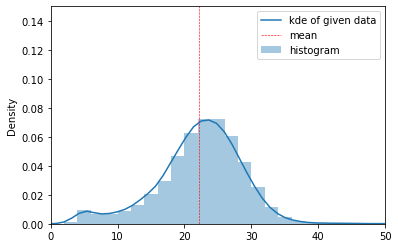

In [397]:
# Lets draw a distribution plot of our data

sns.distplot(original_data, bins = 110, kde_kws={'label':'kde of given data'}, label = 'histogram')
plt.axvline(mean_, color='r', linestyle='dashed', linewidth=0.6, label = 'mean')
plt.axis([0, 50, 0, 0.15])
plt.legend(loc = 1, prop={'size': 10})
plt.show()

#### Lets try to reproduce this distribution artificially.
We can see that this is kind of a normal left-skewed distribution. Lets try to draw normal left-skewed distribution.

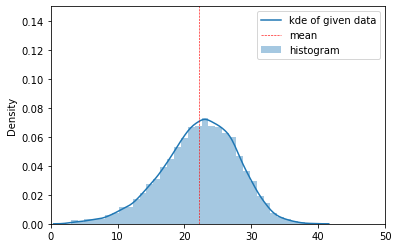

In [396]:

# Create some random data from a skewnorm. with a = -1.8 (meaning left-skewed),
# loc = 28.2, scale = 7.88 and size = 12419 (the original size of our sample)

random_data = skewnorm.rvs(a = -1.8, loc=28.2, scale=7.88, size=12419).astype(np.int)

generated_data = []

for random_ in random_data:

    if random_ <= 2: # in case our random_ value is less than 2 (remamber we have a min of 2 in our original data)
        random_ = abs(i) + 1 
        generated_data.append(random_)
    else:
        generated_data.append(random_)
        
        
mean_ = np.mean(generated_data)
# draw a histogram and kde of the given data
ax = sns.distplot(generated_data, bins = 35, kde_kws={'label':'kde of given data'}, label='histogram')
plt.axvline(mean_, color='r', linestyle='dashed', linewidth=0.6, label = 'mean')
plt.axis([0, 50, 0, 0.15])
plt.legend(loc = 1, prop={'size': 10})
plt.show()

In [364]:
np.mean(generated_data)

22.281987277558578

In [400]:
np.std(generated_data)

5.58734100202661

In [398]:
np.max(generated_data)

39

In [399]:
np.min(generated_data)

3

We can see that mean of the original data (22.264) is close to the mean of the artificially generated data (22.281), the density is almost similar. The peak of density is around 0.079 in both datasets. The standard deviation is 5.587 which is quite low compared to 7.566 which we will gain by generating pecularities: in the original data there is a little hump in a roud of 5, and also there is a maximum of 222, but in our generated data we have a maximum of 39, meaning that the original data also have some long lasting right tail. We have to generate both of this observatons to fit the original data completely.

First lets add the left hump in around of 5.

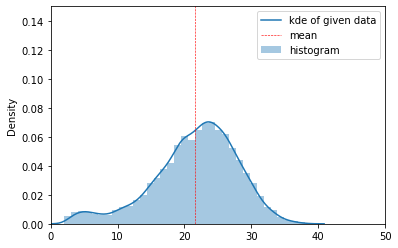

In [447]:


random_data = skewnorm.rvs(a = -1.8, loc=28.2, scale=7.88, size=12419).astype(np.int) # this part stays the same

generated_data = []

for random_ in random_data:
    
    random_number = random.uniform(0,100) # introducing some random uniform number from 0 to 100
    
    if 99.6 > random_number > 96.3: # only in case random_number is between 99.6 and 96.3 the our little hump will rise.
        number = int(np.random.normal(loc = 5.4, scale = 1.8)) # loc = 5.4, scale = 1.8
        if number <= 2: # in case less than 2
            number = abs(number) + 2
        generated_data.append(number)

    elif random_ <= 2: # in case less than 2
        random_ = abs(i) + 1 
        generated_data.append(random_)
    else:
        generated_data.append(random_)
        
        
mean_ = np.mean(generated_data)
# draw a histogram and kde of the given data
ax = sns.distplot(generated_data, bins = 35, kde_kws={'label':'kde of given data'}, label='histogram')
plt.axvline(mean_, color='r', linestyle='dashed', linewidth=0.6, label = 'mean')
plt.axis([0, 50, 0, 0.15])
plt.legend(loc = 1, prop={'size': 10})
plt.show()

From the graph we can see that our little 'hump' appeared in the left tail of our distribution.

Now lets try to generate long right tail. We will use chi-square distribution to achieve needed outcome.

We know that max of our artificially generated data so far is 39. Lets try to add some observations starting from 40, meaning loc in our chi2 = 40

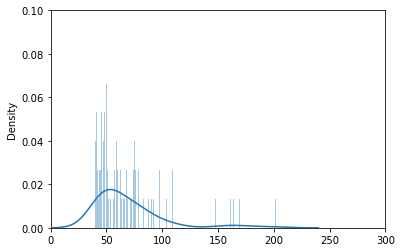

In [451]:
# Example

data = chi2.rvs(2, loc = 40, scale = 15, size=100).astype(np.int)
sns.distplot(data, bins = 215)
plt.axis([0, 300, 0, 0.1])
plt.show()

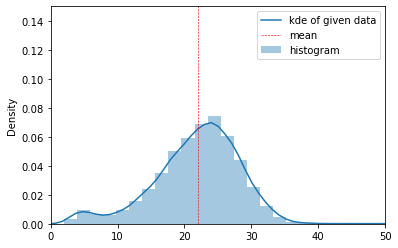

In [620]:


random_data = skewnorm.rvs(a = -1.8, loc=28.2, scale=7.88, size=12419).astype(np.int) # this part stays the same

generated_data = []

for random_ in random_data:
    
    random_number = random.uniform(0,100) # some random uniform number from 0 to 100
    
    if 99.5 > random_number > 96.2:
        number = int(np.random.normal(loc = 5.4, scale = 1.8))
        if number <= 2:
            number = abs(number) + 2
        generated_data.append(number)
        
    elif random_number > 99.5:
        number = chi2.rvs(2, loc = 40, scale = 15).astype(np.int) # added chi2 distribution for long right tail
        generated_data.append(number)

    elif random_ <= 2:
        random_ = abs(i) + 1 
        generated_data.append(random_)
    else:
        generated_data.append(random_)
        
        
mean_ = np.mean(generated_data)
# draw a histogram and kde of the given data
ax = sns.distplot(generated_data, bins = 100, kde_kws={'label':'kde of given data'}, label='histogram')
plt.axvline(mean_, color='r', linestyle='dashed', linewidth=0.6, label = 'mean')
plt.axis([0, 50, 0, 0.15])
plt.legend(loc = 1, prop={'size': 10})
plt.show()

Now we can see that mean and std are almost the same, as well as the number of observations above 40:

In [621]:
np.mean(original_data), np.mean(generated_data)

(22.264836138175376, 22.021579837346003)

In [622]:
np.std(original_data), np.std(generated_data)

(7.566767806239375, 7.308927531495185)

In [623]:
np.max(original_data), np.max(generated_data)

(222, 197)

In [624]:
np.min(original_data), np.min(generated_data)

(2, 2)

In [506]:
# Number of observations above 40
len([x for x in original_data if x>40]), len([x for x in generated_data if x>40])

(62, 51)

Now we can conclude that we have achieved a good approximation of the original distribution so that we can generate our synthetic dataset

In [507]:
#test/validation data generation

def random_distribution():
        random_ = skewnorm.rvs(-1.8, loc=28.2, scale=7.88).astype(np.int)
        random_number = random.uniform(1,100)
        if 99.5 > random_number > 96.2:
            random_ = int(np.random.normal(5.4, 1.8))
            if random_ <= 2:
                random_ = abs(random_) + 2
        elif random_number > 99.5:
            random_ = chi2.rvs(2, loc = 40, scale = 15).astype(np.int)
        else:
            if random_ <= 2:
                random_ = abs(random_) + 1
        return random_
    
def train_valid_test(start = 0, stop = 0, file_name = 'data.txt'):
    global data_to_plot
    data_to_plot = []
    count = 0
    random_ = random_distribution()
    with open(f'{file_name}', 'w') as fo:
        for i in TRAIN_data[start:stop]:
                        
            if count > random_:
                fo.write(f'\n')
                count = 0
                random_ = random_distribution()
                data_to_plot.append(random_)
                
            for x,y in zip(i[0], i[1]):
                fo.write(f'{x} {y}\n')

                count += 1

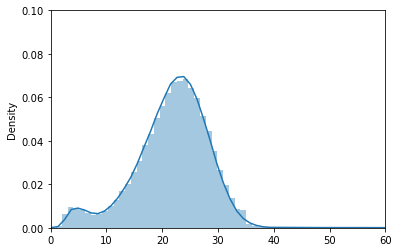

In [508]:
# Generating train sample

train_valid_test(start = 0, stop = len_train_data, file_name = 'train.txt')

# draw a histogram and kde of the given data
ax = sns.distplot(data_to_plot, bins = 225, kde_kws={'label':'kde of given data'}, label='histogram')
plt.axis([0, 60, 0, 0.1])
plt.show()

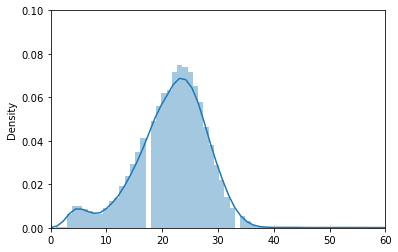

In [512]:
# Generating validation sample

train_valid_test(start = len_train_data, stop = len_train_data + len_validation_data, file_name = 'valid.txt')

# draw a histogram and kde of the given data
ax = sns.distplot(data_to_plot, bins = 225, kde_kws={'label':'kde of given data'}, label='histogram')
plt.axis([0, 60, 0, 0.1])
plt.show()

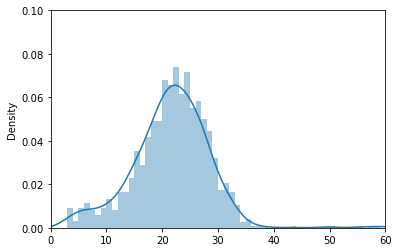

In [608]:
# # Generating test sample == 10k
train_valid_test(start = (len_train_data + len_validation_data), stop = (len_train_data + len_validation_data + 10000), file_name = 'test.txt')

# draw a histogram and kde of the given data
ax = sns.distplot(data_to_plot, bins = 100, kde_kws={'label':'kde of given data'}, label='histogram')
plt.axis([0, 60, 0, 0.1])
plt.show()